In [1]:
library(igraph)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



## 3 Analysing the Traffic Flow
Next December, there is going to be a sport event between Stanford University and University of California, Santa Cruz (UCSC). A large number of students are enthusiastic about the event, which is going to be held in UCSC. Stanford fans want to drive from their campus to the rival’s. We would like to analyse the maximum traffic that can flow
from Stanford to UCSC.

### 3.1 Estimate the Roads
We want to estimate the map of roads without using actual road datasets. Educate yourself about Delaunay triangulation algorithm and then apply it to the nodes coordinates5.

- **Question 11:** Plot the road mesh that you obtain and explain the result. Create a graph GΔ whose nodes are different locations and whose edges are produced by triangulation. 

In [2]:
# wei <- c()
# vertices <- read.csv(file="edge_list_p3.csv", header=FALSE, sep=",")
# for (i in 1:length(vertices$V1)) {
#     vertex_a = vertices$V1[i]
#     vertex_b = vertices$V2[i]
#     dis_ab = distances(g.giant, v=paste0('X', vertex_a), to=paste0('X', vertex_b))[1]
#     wei <- c(wei, dis_ab)
# }

In [3]:
# df = data.frame(id1=vertices$V1, id2=vertices$V2, weight=wei)
# write.csv(df, file="edge_list_p3.csv", row.names=FALSE)
# process edge_list_p3.csv in python to a weight matrix

In [4]:
weight_mat_delta <- as.matrix(read.csv(file="weight_mat_Q11.csv", row.names=1, header=TRUE, sep=","))
g_delta <- graph_from_adjacency_matrix(weight_mat_delta, weighted=TRUE, mode="max")

### 3.2 Calculate Road Traffic Flows

- **Question 12:** Using simple math, calculate the traffic flow for each road in terms of cars/hour.

Hint: Consider the following assumptions:
- Each degree of latitude and longitude = 69 miles
- Car length = 5 m = 0.003 mile
- Cars maintain a safety distance of 2 seconds to the next car
- Each road has 2 lanes in each direction

Assuming no traffic jam, consider the calculated traffic flow as the max
capacity of each road.

In [5]:
id_lon_lat <- read.csv(file="id_long_lat.csv", header=TRUE, sep=",")

get_traffic_flow <- function(vertex_1, vertex_2) {
    travel_time = distances(g_delta, v=vertex_1, to=vertex_2)[1] # in second

    lon1 = id_lon_lat$long[id_lon_lat$id==vertex_1]
    lon2 = id_lon_lat$long[id_lon_lat$id==vertex_2]
    lat1 = id_lon_lat$lat[id_lon_lat$id==vertex_1]
    lat2 = id_lon_lat$lat[id_lon_lat$id==vertex_2]

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 69 * c # in mile

    car_speed = distance / travel_time # in mile / second
    car_length = 0.003 # in mile

    flowrate = 60 * 60 / (car_length / car_speed + 0.2)
    
    return(flowrate)
}

In [6]:
numOfEdge = length(E(g_delta))

for (i in 1:numOfEdge) {
    edge <- E(g_delta)[i]
    Vnames = ends(g_delta, edge, names = TRUE)
    E(g_delta)[i]$capacity <- get_traffic_flow(Vnames[1], Vnames[2])
}

In [7]:
for (i in 1:10) {
    print(E(g_delta)[i])
    print(E(g_delta)[i]$capacity)
}

+ 1/5627 edge from 394aa57 (vertex names):
[1] X2--X395
[1] 4555.908
+ 1/5627 edge from 394aa57 (vertex names):
[1] X2--X818
[1] 3479.782
+ 1/5627 edge from 394aa57 (vertex names):
[1] X2--X1470
[1] 3696.549
+ 1/5627 edge from 394aa57 (vertex names):
[1] X2--X1727
[1] 3192.075
+ 1/5627 edge from 394aa57 (vertex names):
[1] X2--X1733
[1] 4432.404
+ 1/5627 edge from 394aa57 (vertex names):
[1] X2--X2352
[1] 4420.585
+ 1/5627 edge from 394aa57 (vertex names):
[1] X9--X20
[1] 2377.345
+ 1/5627 edge from 394aa57 (vertex names):
[1] X9--X643
[1] 2681.424
+ 1/5627 edge from 394aa57 (vertex names):
[1] X9--X644
[1] 1513.389
+ 1/5627 edge from 394aa57 (vertex names):
[1] X9--X905
[1] 1456.62


### 3.3 Calculate the Max Flow
Consider the following addresses:
1. Source address: 100 Campus Drive, Stanford
2. Destination address: 700 Meder Street, Santa Cruz

- **Question 13:** Calculate the maximum number of cars that can commute per hour from Stanford to UCSC. Also calculate the number of edge-disjoint paths between the two spots. Does the number of edgedisjoint paths match what you see on your road map?

In [8]:
id_addr <- read.csv(file="id_addr.csv", header=TRUE, sep=",")

staNode = V(g_delta)[paste0("X", id_addr$id[id_addr$addr == "100 Campus Drive, Stanford"])]
SCNode = V(g_delta)[paste0("X", id_addr$id[id_addr$addr == "700 Meder Street, Santa Cruz"])]

In [9]:
edge_disjoint_path = edge_connectivity(g_delta, source = staNode, target = SCNode, checks = F)

In [10]:
edge_disjoint_path

[1] 5

In [11]:
MF = max_flow(g_delta, staNode, SCNode, capacity = NULL)
MF$value

[1] 20841.23

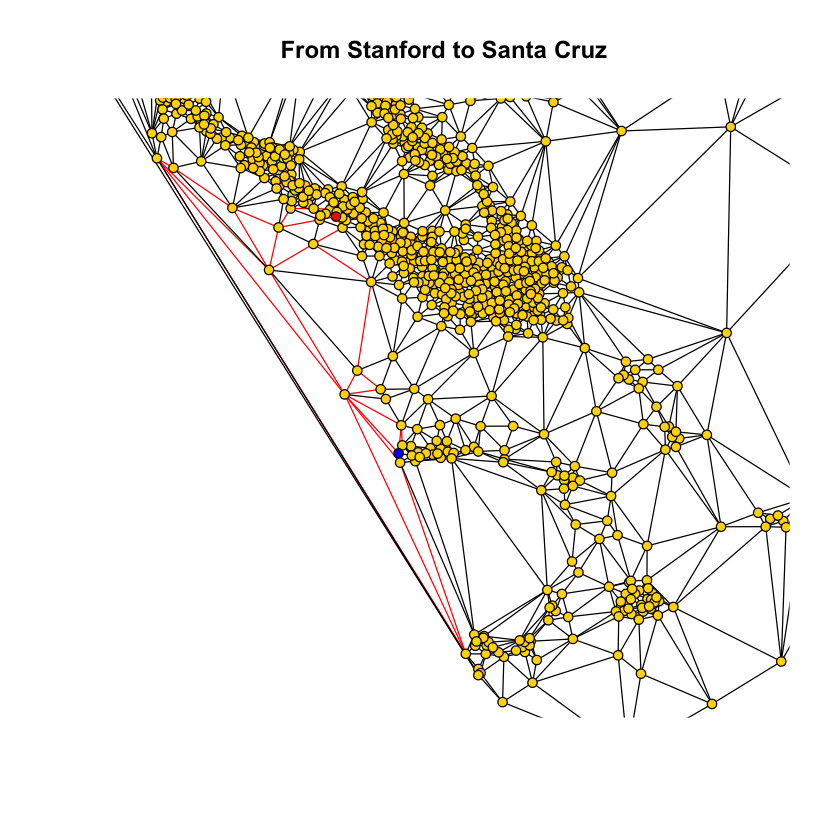

In [13]:
id_coord <-read.csv(file="id_long_lat.csv", header=TRUE, sep=",")

E(g_delta)$color = "black"
E(g_delta)$color[MF$flow!=0] ="red"

V(g_delta)$color <- "gold"
V(g_delta)[paste0("X", id_addr$id[id_addr$addr == "700 Meder Street, Santa Cruz"])]$color <- "blue"
V(g_delta)[paste0("X", id_addr$id[id_addr$addr == "100 Campus Drive, Stanford"])]$color <- "red"

numOfNode = length(V(g_delta))
g_delta_layout = matrix(0.0, nrow=numOfNode, ncol = 2 )
for (i in 1:numOfNode)
{
    g_delta_layout[i,1] = id_coord$long[id_coord$id == V(g_delta)[i]$name]
    g_delta_layout[i,2] = id_coord$lat[id_coord$id == V(g_delta)[i]$name]
}

plot(g_delta, layout = g_delta_layout, vertex.size=1.5, vertex.label=NA, main="From Stanford to Santa Cruz", edge.color = E(g_delta)$color,
    vertex.color = V(g_delta)$color, xlim = c(-0.45, 0.45), ylim = c(-0.9, 0))

## 3.4 Defoliate Your Graph
In GΔ, there are a number of unreal roads that could be removed. For instance, there are many fake bridges crossing the bay. Apply a threshold on the travel time of the roads in GΔ to remove the fake edges. Trim the fake edges and call the resulting graph ~GΔ.

- **Question 14:** Plot ~GΔ on real map coordinates. Are real bridges preserved?

    Hint: You can consider the following coordinates:
    - Golden Gate Bridge: [[-122.475, 37.806], [-122.479, 37.83]]
    - Richmond, San Rafael Bridge: [[-122.501, 37.956], [-122.387, 37.93]]
    - San Mateo Bridge: [[-122.273, 37.563], [-122.122, 37.627]]
    - Dambarton Bridge: [[-122.142, 37.486], [-122.067, 37.54]]
    - San Francisco - Oakland Bay Bridge: [[-122.388, 37.788], [-122.302, 37.825]]

[1] 5345

[1] 5627

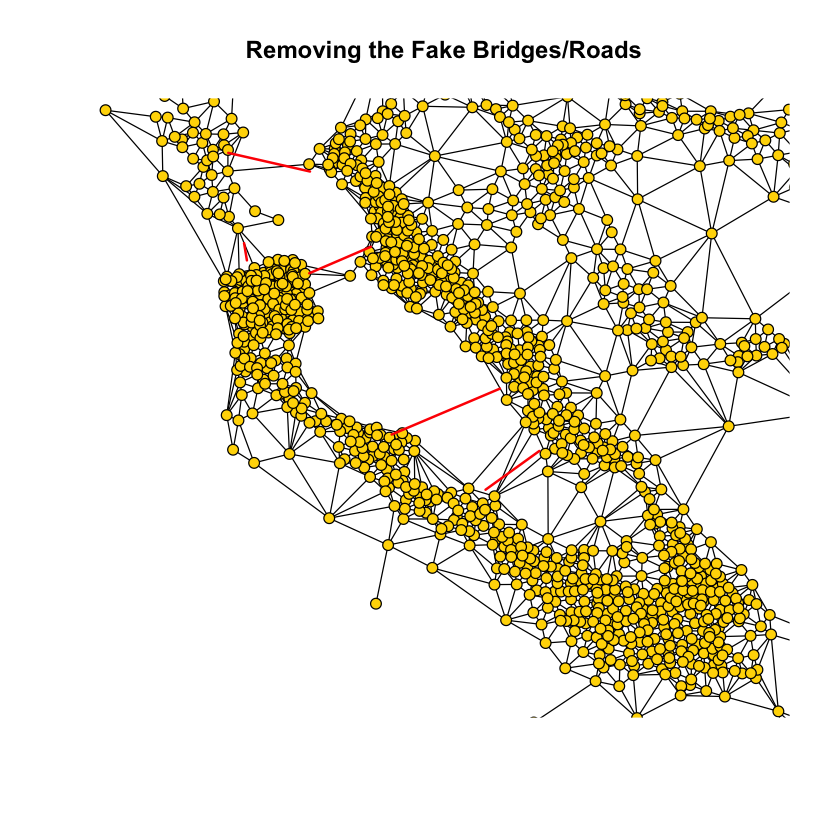

In [14]:
edgeThreshold <- quantile(E(g_delta)$weight, 0.95) 
delEdges <- E(g_delta)[E(g_delta)$weight > edgeThreshold]
new_g_delta <- delete_edges(g_delta, delEdges)
length(E(new_g_delta))
length(E(g_delta))

E(new_g_delta)$color = "black"
V(new_g_delta)$color = "gold"
plot(new_g_delta, layout = g_delta_layout, vertex.size=1.5, vertex.label=NA, main="Removing the Fake Bridges/Roads", edge.color = E(new_g_delta)$color,
    vertex.color = V(new_g_delta)$color, rescale = FALSE, xlim = c(-122.6, -121.8), ylim = c(37.2, 38))

lines(c(-122.475, -122.479), c(37.806, 37.83), type = "l", col = "red", lwd = 2)
lines(c(-122.501, -122.387), c(37.956, 37.93), type = "l", col = "red", lwd = 2)
lines(c(-122.273, -122.122), c(37.563, 37.627), type = "l", col = "red", lwd = 2)
lines(c(-122.142, -122.067), c(37.486, 37.54), type = "l", col = "red", lwd = 2)
lines(c(-122.388, -122.302), c(37.788, 37.825), type = "l", col = "red", lwd = 2)


- **Question 15:** Now, repeat question 8 for ~GΔ and report the results. Do you see any significant changes?

In [15]:
staNode = V(new_g_delta)[paste0("X", id_addr$id[id_addr$addr == "100 Campus Drive, Stanford"])]
SCNode = V(new_g_delta)[paste0("X", id_addr$id[id_addr$addr == "700 Meder Street, Santa Cruz"])]
MF = max_flow(new_g_delta, staNode, SCNode, capacity = NULL)
MF$value
edge_disjoint_path = edge_connectivity(new_g_delta, source = staNode, target = SCNode, checks = F)
edge_disjoint_path

[1] 20841.23

[1] 5

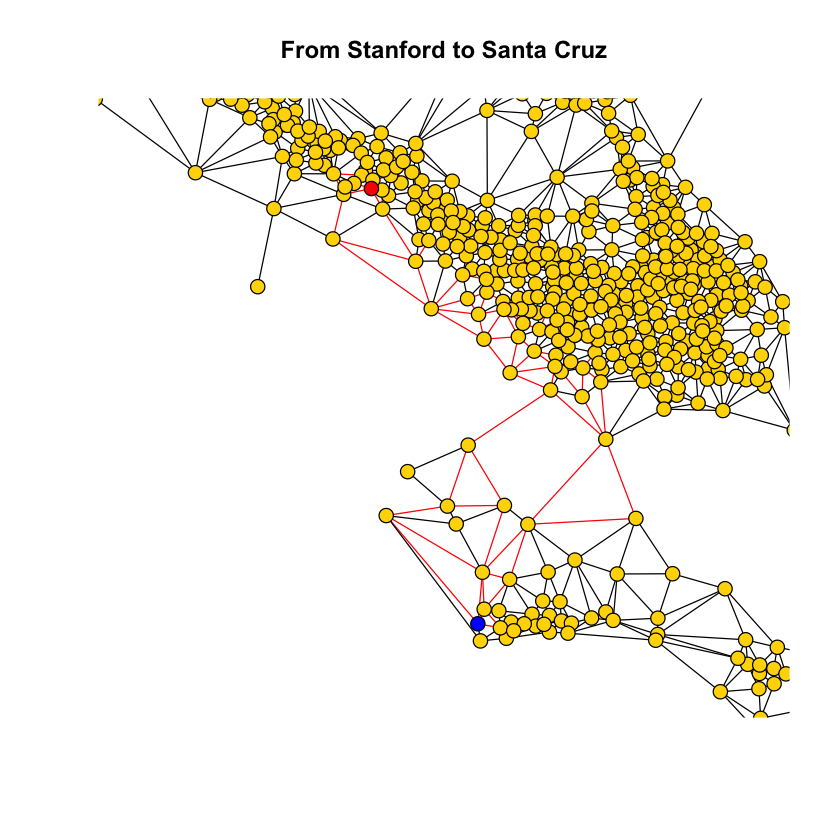

In [16]:
E(new_g_delta)$color[MF$flow!=0] ="red"

V(new_g_delta)[paste0("X", id_addr$id[id_addr$addr == "700 Meder Street, Santa Cruz"])]$color <- "blue"
V(new_g_delta)[paste0("X", id_addr$id[id_addr$addr == "100 Campus Drive, Stanford"])]$color <- "red"


plot(new_g_delta, layout = g_delta_layout, vertex.size=1.5, vertex.label=NA, main="From Stanford to Santa Cruz", edge.color = E(new_g_delta)$color,
    vertex.color = V(new_g_delta)$color, rescale = FALSE, xlim = c(-122.4, -121.8), ylim = c(36.9, 37.5))